In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

%matplotlib inline
import matplotlib.pyplot as plt

# Read in Raw Data

In [2]:
TRAIN_DATA_PATH = '../data/commute-times-train.csv'
TEST_DATA_PATH = '../data/commute-times-test.csv'

In [3]:
train_data_raw = pd.read_csv(TRAIN_DATA_PATH, 
                             parse_dates=['time_of_day_ts'])
test_data_raw = pd.read_csv(TEST_DATA_PATH,
                            parse_dates=['time_of_day_ts'])

In [4]:
train_data_raw['dataset'] = 'TRAIN'
test_data_raw['dataset'] = 'TEST'

raw_data = pd.concat([train_data_raw, test_data_raw])

# Raw Data (One Variable) Visualizations

## Source and Destination of Commute

Text(0.5,1,'Destination Of Commute Lat, Long')

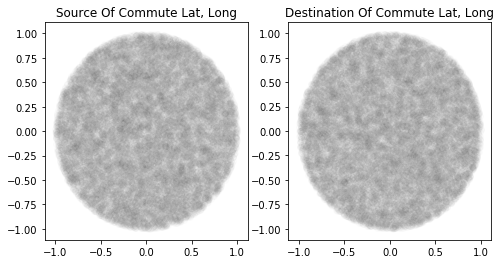

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(train_data_raw['source_latitude'],
               train_data_raw['source_longitude'],
               color="grey", alpha=0.02)
axs[0].set_title("Source Of Commute Lat, Long")
axs[1].scatter(train_data_raw['destination_latitude'],
               train_data_raw['destination_longitude'],
               color="grey", alpha=0.02)
axs[1].set_title("Destination Of Commute Lat, Long")

## Count of Commute Types

Text(0,0.5,'Volume of Commutes')

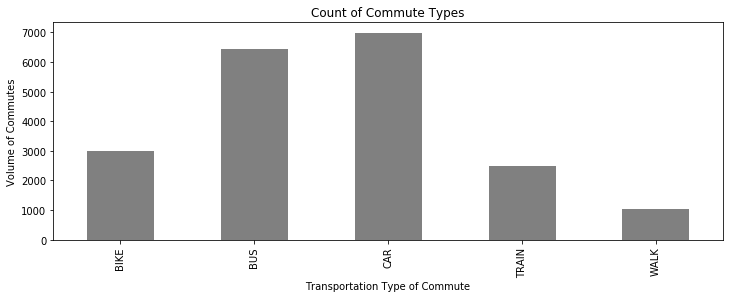

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw.groupby('commute_type').size().plot(
    ax=ax, kind='bar', color="grey")
ax.set_title("Count of Commute Types")
ax.set_xlabel("Transportation Type of Commute")
ax.set_ylabel("Volume of Commutes")

## Distribution of Commute Time

Text(0,0.5,'Volume of Commutes')

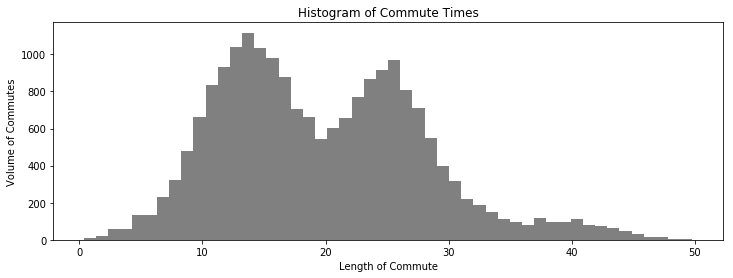

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['commute_time'].plot(
    ax=ax, kind='hist', bins=50, color="grey")
ax.set_title("Histogram of Commute Times")
ax.set_xlabel("Length of Commute")
ax.set_ylabel("Volume of Commutes")

**Discussion.**

Discuss multi-modal nature.  What could be causing that?  **A:** We may have different subpopulations in the data with different commute time behaviour, transportation type is a possibility.

## Distribution of Time of Day

We'd like to draw a histogram of time of day, but this is not easy to do on the raw timestamp data.  To make our lives easy, we'll convert this into a decimal between zero and twenty-four.

In [8]:
def timestamp_to_decimal(ts):
    """Convert a timestamp datum into a decimal between zero and twenty-four.
    
    Parameters
    ----------
    ts: pd.Series of datetime.
    """
    return ts.dt.hour + (1/60)*ts.dt.minute

train_data_raw['time_of_day'] = timestamp_to_decimal(
    train_data_raw['time_of_day_ts'])
test_data_raw['time_of_day'] = timestamp_to_decimal(
    test_data_raw['time_of_day_ts'])

Notice how we have to apply the **same transformation** to our training and testing data.  I'll show you a trick soon that will save us some trouble.

Text(0,0.5,'Volume of Commutes')

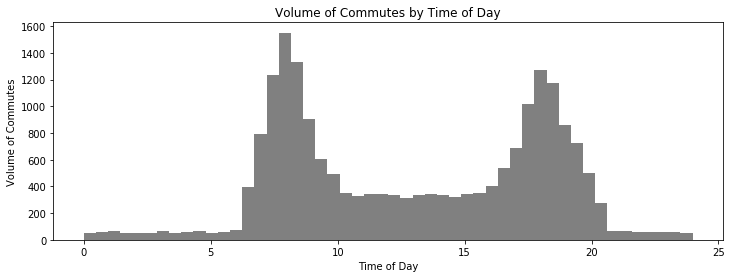

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['time_of_day'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Volume of Commutes by Time of Day")
ax.set_xlabel("Time of Day")
ax.set_ylabel("Volume of Commutes")

**Discussion**

We would expect high volume times to have longer commutes.  Plotting the commute time by the time of day may give some insight into the situation.

## Distance of Commute

The distance of the commute is not explicitly included in the dataset!  Instead, we have the coordinates of the source and destination of the commute.  This should allow us to calculate the distance of the commute, but we have a couple of options:

  - The **Euclidean Distance** is the straight line distance between the source and the target.  It is calucated from the usual formula inspired by the Pythagorean Theorem.

In [10]:
def euclidean_distance(source_x, source_y, target_x, target_y):
    return np.sqrt((source_x - target_x)**2 + (source_y - target_y)**2)

train_data_raw['euclidean_distance'] = euclidean_distance(
    train_data_raw['source_latitude'], train_data_raw['source_longitude'],
    train_data_raw['destination_latitude'], train_data_raw['destination_longitude'])
test_data_raw['euclidean_distance'] = euclidean_distance(
    test_data_raw['source_latitude'], test_data_raw['source_longitude'],
    test_data_raw['destination_latitude'], test_data_raw['destination_longitude'])

Text(0,0.5,'Volume of Commutes')

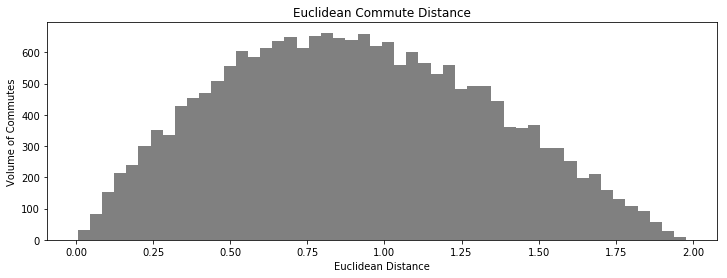

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['euclidean_distance'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Euclidean Commute Distance")
ax.set_xlabel("Euclidean Distance")
ax.set_ylabel("Volume of Commutes")

  - The **Taxicab Distance** is the total distance a car would travel between the source and destination coordinates *if it only traveled parallel to the x and y axies*.

In [12]:
def taxicab_distance(source_x, source_y, target_x, target_y):
    return np.abs(source_x - target_x) + np.abs(source_y - target_y)

train_data_raw['taxicab_distance'] = taxicab_distance(
    train_data_raw['source_latitude'], train_data_raw['source_longitude'],
    train_data_raw['destination_latitude'], train_data_raw['destination_longitude'])
test_data_raw['taxicab_distance'] = taxicab_distance(
    test_data_raw['source_latitude'], test_data_raw['source_longitude'],
    test_data_raw['destination_latitude'], test_data_raw['destination_longitude'])

Text(0,0.5,'Volume of Commutes')

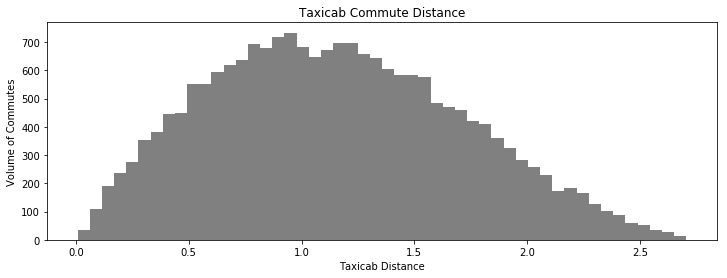

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['taxicab_distance'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Taxicab Commute Distance")
ax.set_xlabel("Taxicab Distance")
ax.set_ylabel("Volume of Commutes")

**Discussion**

Which distance measure do you think more likely to be related to the commute time?  Why?

# Relationship Visualizations

## The Effect Of Commute Type on Commute Time

Let's try to look into the relationship between the commute type and commute time.  We have hypothesized that the commute type may have something to do with the multi-modal behaviour of commute time.

A powerful technique in this area is the principle of **small multiples**, draw many small seperate plots in a way that the readers eye can easily compare them.

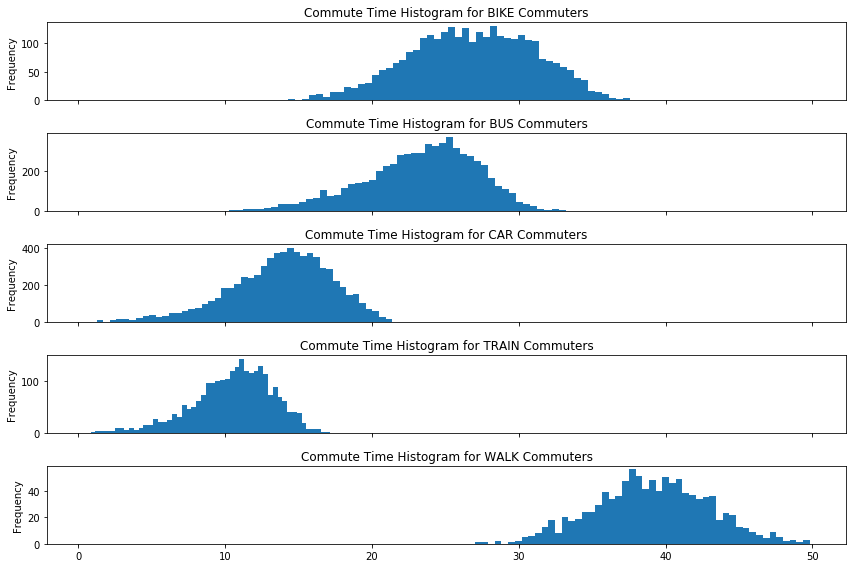

In [14]:
# Get a list of all the unique commute types.
commute_types = np.unique(train_data_raw['commute_type'])

# We want one axis (i.e. on plotting area) for each commute type.
# Note the sharey argument, this forces all out plots to have the 
# same x-axis range.
fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

# Subset the data by each commute type, then plot a histogram of commute
# times for each seperate commute type individually.
for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_for_commute_type['commute_time'].plot(ax=ax, kind="hist", bins=50)
    ax.set_title(f"Commute Time Histogram for {commute_type} Commuters")

fig.tight_layout()

It looks like the commute time definately has an effect.

The results here are intuitive:  train commutes are speedy, while walking or biking to work takes longer.

Here's an alternative visualization of this effect (though making this one is a bit more involved).

In [15]:
def convert_to_numeric(catagorical):
    classes = list(sorted(catagorical.unique()))
    classes_mapping = {cls: i for i, cls in enumerate(classes)}
    classes_inv_mapping = {i: cls for i, cls in enumerate(classes)}
    classes_numeric = catagorical.apply(lambda cls: classes_mapping[cls])
    return classes_numeric, classes_inv_mapping

def catagorical_plot(ax, catagorical, y, jitter_width=0.1, box=True):
    numeric, classes_mapping = convert_to_numeric(catagorical)
    # This is called adding "jitter" to a scatterplot.
    noise = np.random.normal(0.0, jitter_width, size=len(catagorical))
    ax.scatter(numeric + noise, y, color="grey", alpha=0.1, label="Data")
    
    box_data = list(y.groupby(numeric))
    if box:
        ax.boxplot([data for _, data in box_data], positions=range(len(box_data)))
    ax.set_xticks(list(classes_mapping))
    ax.set_xticklabels([classes_mapping[name] for name, _ in box_data])

Text(0.5,1,'Effect of Commute Type on Commute Time')

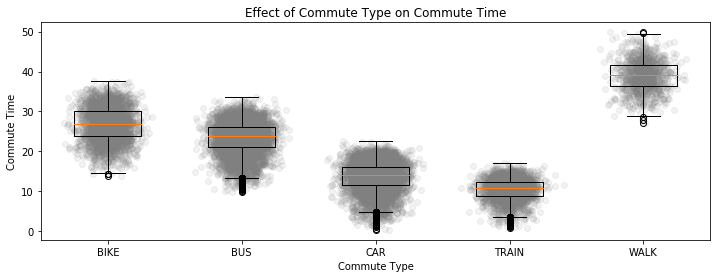

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))

catagorical_plot(ax, train_data_raw['commute_type'], train_data_raw['commute_time'])
ax.set_xlabel("Commute Type")
ax.set_ylabel("Commute Time")
ax.set_title("Effect of Commute Type on Commute Time")

This tells the same story in a different way.  Here we see each individual commute time as a point, so all the data is represented exactly.  Each cloud of points are the commute times for each individual type of commute.

The left-right scatter within each type of commute is not meaningful, it just serves to spread the points out so our eye can get an idea of what is going on.  If we take away the scatter, it looks really bad:

Text(0.5,1,'Effect of Commute Type on Commute Time')

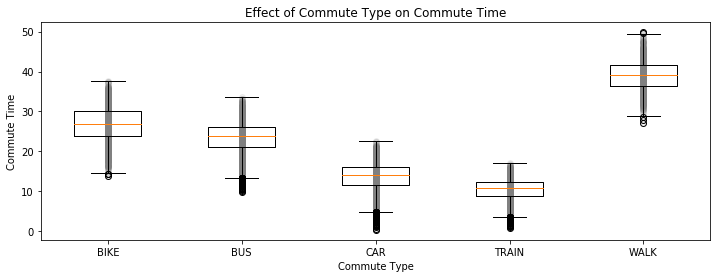

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

catagorical_plot(ax, 
                 train_data_raw['commute_type'], 
                 train_data_raw['commute_time'],
                 jitter_width=0.0)
ax.set_xlabel("Commute Type")
ax.set_ylabel("Commute Time")
ax.set_title("Effect of Commute Type on Commute Time")

Not as good!

**Discussion**

Do you expect commute type to be predictive of commute time?

## The Effect of Commute Distance on Commute Time

A scatter plot of commute time by commute distance can be illuminating.

Text(0.5,1,'Commute Time by Euclidean Commute Distance')

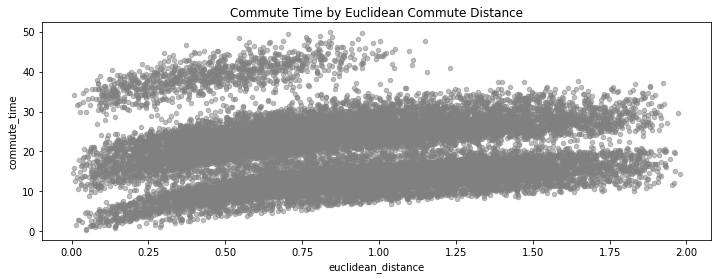

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='euclidean_distance', y='commute_time',
                    color='gray', alpha=0.5)
ax.set_title("Commute Time by Euclidean Commute Distance")

Text(0.5,1,'Commute Time by Taxicab Commute Distance')

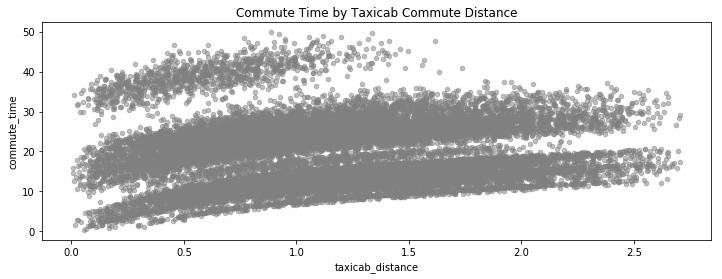

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                    color='gray', alpha=0.5)
ax.set_title("Commute Time by Taxicab Commute Distance")

There is clearly a realationship between commute distance and commute time!  Though it is subtle:

  - There is *definately* some overall relationship between the distance of the commute and the time of the commute.  Commutes covering a larger distance tend to take longer, which makes intuitive sense.
  - There is some interesting *banding* in these plots.  The relationships seem to fall into different catagories.
  - The structure of the Taxicab distance plot is more defined than the structure of the Euclidean distance plot.  This maybe leads us to suspect that the taxicab distance is closer to capturing some essential truth of the situation.

Let's look into the banding.  We suspect that each defined band is some subpopulation of our commuters.  We have a clear canidate for what this could be, out commute type variable.

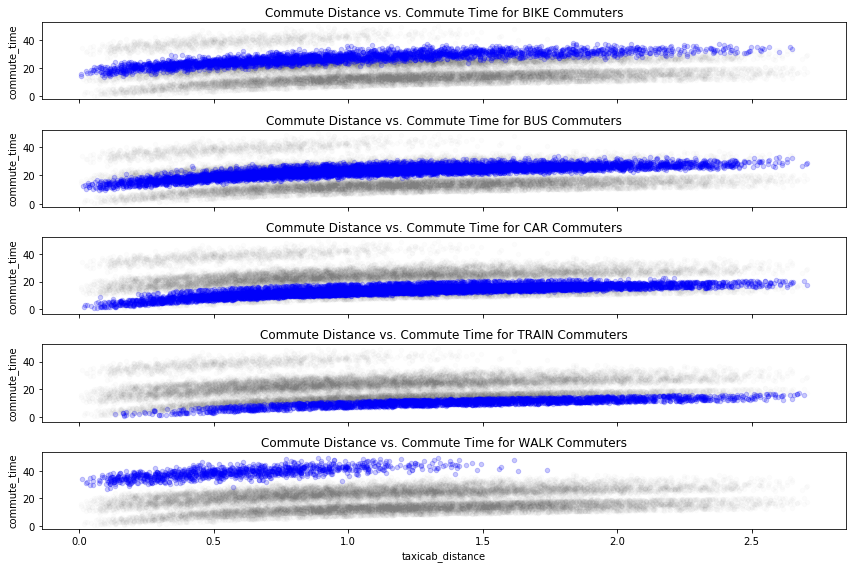

In [20]:
# This code is based on the example from eariler which creates histograms of 
# commute time for each individual commute type.
commute_types = np.unique(train_data_raw['commute_type'])

fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_data_raw.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='gray', alpha=0.02)
    train_for_commute_type.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='blue', alpha=0.2)
    ax.set_title(f"Commute Distance vs. Commute Time for {commute_type} Commuters")

fig.tight_layout()

We see clearly that the banding structure in the scatterplot is caused by the different types of commute.

## The Effect of Time of Day on Commute Time

Finally, let's look into the relationship between the commute time and the time of day.

Text(0.5,1,'Commute Time by Time of Day')

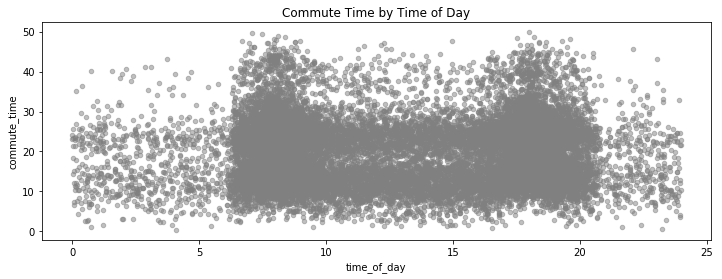

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='time_of_day', y='commute_time',
                    color='gray', alpha=0.5)
ax.set_title("Commute Time by Time of Day")

We again see some banding structure, so lets break it out by commute type to get a clearer picture of what's going on.

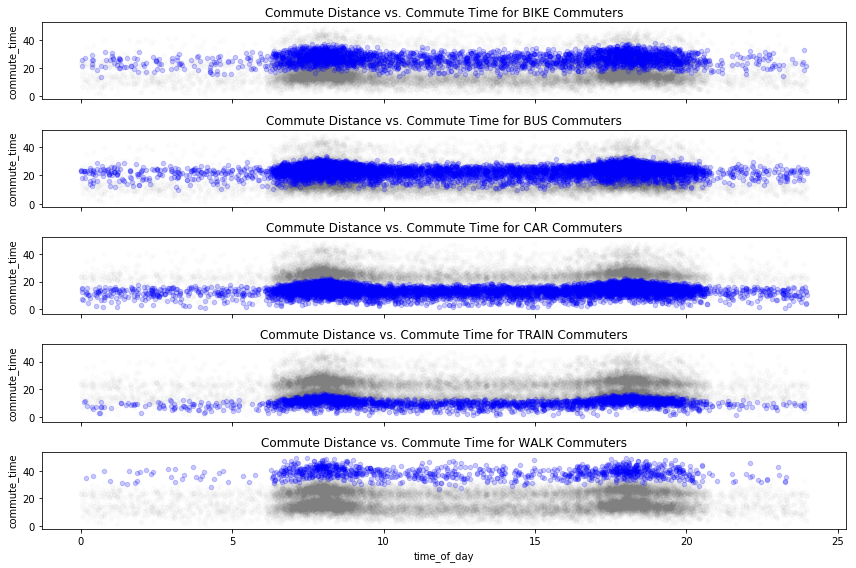

In [22]:
commute_types = np.unique(train_data_raw['commute_type'])

fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_data_raw.plot(
        ax=ax, kind="scatter", 
        x='time_of_day', y='commute_time',
        color='gray', alpha=0.02)
    train_for_commute_type.plot(
        ax=ax, kind="scatter", 
        x='time_of_day', y='commute_time',
        color='blue', alpha=0.2)
    ax.set_title(f"Commute Distance vs. Commute Time for {commute_type} Commuters")

fig.tight_layout()

Similar to before, the bands are caused by the different commute types.

The relationship between time of day and commute time is subtle.  It's definately not in increasing style of relationship (nor could it be...).  Instead, it looks like commute times are largely driven by the distance, but they tend to be longer during high traffic times of day.

# Linear Regression

Our goal now is to use the information we've learned from data exploration to build a predictive model that uses the features in the data to make a predicton of commute time.

The most important foundational technique for doing this is called **linear regression**.

## Using Commute Type to Predict Commute Time

Let's start with the commute type features.  We are almost certain from our data exploration that this feature has a strong influence on the commute time, so let's see if we're right.

Its a general fact about predictive models that they cannot handle raw catagorical data, like our commute time column.  Instead, whenever you would like to use a catagorical measurement to make predictions, it is neccessary to turn it into some number of **indicator variables**, usually one for each catagory.

In [23]:
def create_indicator_features(feature, leave_one_out=True):
    # Sort the levels so we always get the same ordering of new features.
    levels = list(sorted(np.unique(feature)))
    # If we need to leave one out to avoid identifiability issues, we will 
    # leave out the *last* level, in sorted order.
    if leave_one_out:
        levels = levels[:-1]
    indicator_features = []
    for level in levels:
        indicator_feature = (feature == level)
        indicator_feature_name = f"is_{level}"
        indicator_features.append(
            pd.Series(indicator_feature, 
                      name=indicator_feature_name, 
                      index=feature.index,
                      dtype=int))
    return pd.concat(indicator_features, axis=1)

In [24]:
commute_type_features_train = create_indicator_features(train_data_raw['commute_type'])
commute_type_features_test = create_indicator_features(test_data_raw['commute_type'])

commute_type_features_train.head()

,is_BIKE,is_BUS,is_CAR,is_TRAIN
0,0,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,0,0,1


In [25]:
train_data_raw = pd.concat([train_data_raw, commute_type_features_train], axis=1)
test_data_raw = pd.concat([test_data_raw, commute_type_features_train], axis=1)

train_data_raw.head()

,Unnamed: 0,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day_ts,commute_type,commute_time,dataset,time_of_day,euclidean_distance,taxicab_distance,is_BIKE,is_BUS,is_CAR,is_TRAIN
0,0,-0.182809,0.361579,0.485623,0.300347,2018-08-13 16:56:00,BUS,25.156297,TRAIN,16.933333,0.671231,0.729664,0,1,0,0
1,1,0.160297,0.064330,0.702545,-0.116307,2018-08-13 18:19:00,CAR,12.937429,TRAIN,18.316667,0.571544,0.722885,0,0,1,0
2,2,0.762229,0.486693,0.197252,0.790051,2018-08-13 17:36:00,BIKE,29.013729,TRAIN,17.600000,0.641268,0.868335,1,0,0,0
3,3,0.187947,0.508487,-0.372924,-0.914006,2018-08-13 07:41:00,CAR,18.215423,TRAIN,7.683333,1.529073,1.983364,0,0,1,0
4,4,-0.431013,-0.600620,0.729273,0.215633,2018-08-13 15:56:00,TRAIN,11.196802,TRAIN,15.933333,1.418637,1.976539,0,0,0,1


We're prepared now.

We're goning to fit a linear regression model which uses the commute type information to predict the commute distance.  The result of this will be an equation:

$$ \text{Commute Time} \approx \beta_0 + \beta_1 \times \text{is_BIKE} + \beta_2 \times \text{is_BUS} + \beta_3 \times \text{is_CAR} + \beta_4 \times \text{is_TRAIN} $$

The $\beta$ things are just numbers.  The whole idea is to use the **data** to choose the numbers $\beta_0, \beta_1, \ldots, \beta_4$ so that the equation above is the **most descriptive of the data possible**.

When we call the `LinearRegression.fit` function below, this is what's happening.

In [26]:
feature_names = ['is_BIKE', 'is_BUS', 'is_CAR', 'is_TRAIN']

train_data_only_commute_type = train_data_raw.loc[:, feature_names]
test_data_only_commute_type = test_data_raw.loc[:, feature_names]

In [27]:
model_only_commute_type = LinearRegression()
model_only_commute_type.fit(train_data_only_commute_type, train_data_raw['commute_time'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Once we've fit the model to our data, the beta numbers are available from the model object:

  - The `model.intercept_` attribute contains $\beta_0$.
  - The `model.coef_` attribute contains $\beta_1, \beta_2, \ldots$

In [28]:
model_only_commute_type.intercept_

39.052193089117495

In [29]:
model_only_commute_type.coef_

array([-12.22137668, -15.70403129, -25.29156173, -28.49699936])

Unfortunately, the model object does **not** remember the names of the features, so let's write a function to stitch together the names of the features with the values of the betas.

In [30]:
def print_betas(model, feature_names):
    feature_names = ["Intercept"] + feature_names
    betas = [model.intercept_] + list(model.coef_)
    for name, beta in zip(feature_names, betas):
        print(f"{name:<20}: {beta:2.2f}")

In [31]:
print_betas(model_only_commute_type, feature_names)

Intercept           : 39.05
is_BIKE             : -12.22
is_BUS              : -15.70
is_CAR              : -25.29
is_TRAIN            : -28.50


Now let's interpret this in light of our equation:

$$ \begin{align} \text{Commute Time} \ \approx \ & \beta_0 + \beta_1 \times \text{is_BIKE} \\&+ \beta_2 \times \text{is_BUS} \\&+ \beta_3 \times \text{is_CAR} \\&+ \beta_4 \times \text{is_TRAIN}\\ \end{align} $$

Which we can now plug numbers into:

$$ \begin{align} \text{Commute Time} \ \approx \ & 39.05 - 12.22 \times \text{is_BIKE} \\&- 15.70 \times \text{is_BUS} \\&- 25.29 \times \text{is_CAR} \\&- 28.50 \times \text{is_TRAIN}\\ \end{align} $$

We can play with this a bit to get some intuition.  For example, the predicted commute time for bike commuters is:

$$ \text{Commute Time} \approx 39.05 - 12.22 \times 1 - 15.70 \times 0 - 25.29 \times 0 - 28.50 \times 0 = 26.83 $$

And the predicted commute time for train commuters is:

$$ \text{Commute Time} \approx 39.05 - 12.22 \times 0 - 15.70 \times 0 - 25.29 \times 0 - 28.50 \times 1 = 10.55 $$

**Discussion:**

How can we get the predicted commute time for walk commuters?

Working though this by hand (there are better ways to do this, I'll show you soon), we get the following predicted values for each commute type.

In [32]:
predictions_by_commute_type = {
    'BIKE': 26.83,
    'BUS': 23.25,
    'CAR': 13.75,
    'TRAIN': 10.55,
    'WALK': 39.05
}

Let's superimpose this on our scatter plot of this relationship from earlier to hopefully see what's going on:

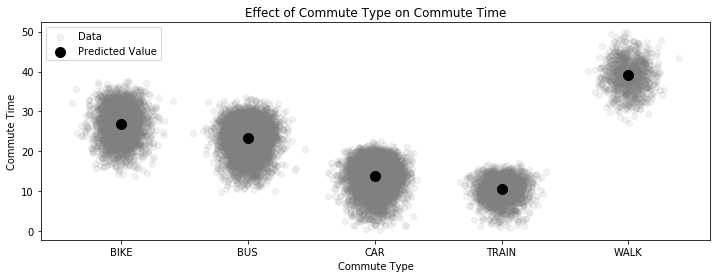

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))

catagorical_plot(ax, train_data_raw['commute_type'], train_data_raw['commute_time'], box=False)
ax.scatter(range(5), predictions_by_commute_type.values(),
           color="black", s=100, label="Predicted Value")
ax.set_xlabel("Commute Type")
ax.set_ylabel("Commute Time")
ax.set_title("Effect of Commute Type on Commute Time")
ax.legend()

This looks reasonable.  Although the actual commute times vary alot within each group, the predictions from the model find the ceanter of each group.  This is about the best we could ask for.

## Using Commute Distance to Predict Commute Time

Now lets turn to a different type of variable, the commute distance.

Here's our plot of the relationship from earlier:

Text(0.5,1,'Commute Time by Taxicab Commute Distance')

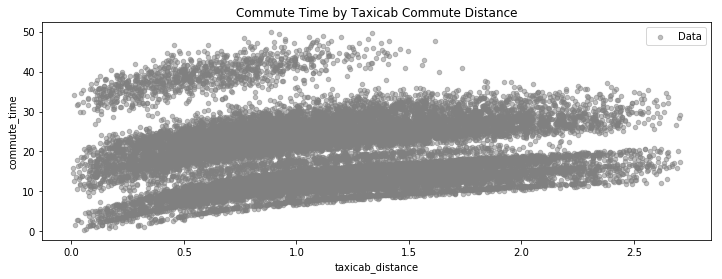

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                    color='gray', alpha=0.5, label="Data")
ax.set_title("Commute Time by Taxicab Commute Distance")

We saw that the commute time tends to increase with the distance covered.

Whereas our previous example used a catagorical feature in the model, this time we have a **continuous** feature.  There are many ways to handle continuous features in a linear regression model, but we will focus on the most basic way today, fitting a line through the feature.  This will give us an equation like:

$$ \text{Commute Time} \approx \beta_0 + \beta_1 \times \text{Commute Distance} $$

This is actually easier than before, we don't need to fuss with the feature at all, since it is already numeric (as oppsed to the commute type feature, which was not).

In [35]:
feature_names = ['taxicab_distance']

train_data_only_distance = train_data_raw.loc[:, feature_names]
test_data_only_distance = test_data_raw.loc[:, feature_names]

In [36]:
model_only_distance = LinearRegression()
model_only_distance.fit(train_data_only_distance, train_data_raw['commute_time'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
print_betas(model_only_distance, feature_names)

Intercept           : 18.43
taxicab_distance    : 1.14


So we got the following equation which best describes our data:

$$ \text{Commute Time} \approx 18.43 + 1.14 \times \text{Commute Distance} $$

It's good that the coefficient of commute distance came out to a **positive** number.  At the very least our model confirms that longer distances are paired with longer commute times.  If it had come out the other way around, we would have reason to doubt our work!

The equation we recieved from the model describes a line (it looks like `m x + b`, in classic algebra style.  This observation allows us to plot the relationship between comute time, and our prediction of commute time.

In [43]:
def plot_line(ax, slope, intercept, linewidth=3, color="black"):
    t = np.linspace(0.0, 3.0, num=250)
    ax.plot(t, intercept + slope * t, label="Predictions", 
            linewidth=linewidth, color=color)

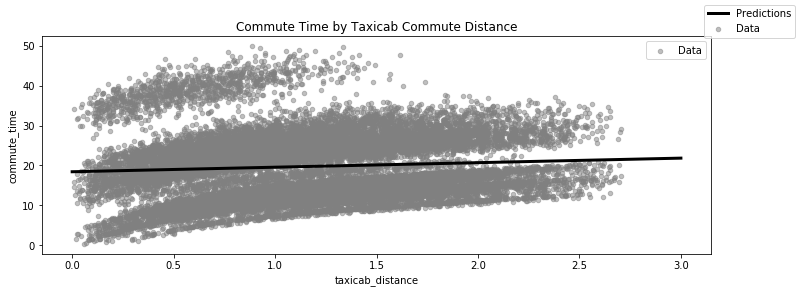

In [46]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                    color='gray', alpha=0.5, label="Data")
plot_line(ax, model_only_distance.coef_, model_only_distance.intercept_)
ax.set_title("Commute Time by Taxicab Commute Distance")
fig.legend()

Hmm, not so pretty.

**Discussion**

Why does this line look so flat?  Is there any way we can remedy it?

## Using Both to Predict Commute Time

In [50]:
feature_names = ['is_BIKE', 'is_BUS', 'is_CAR', 'is_TRAIN', 'taxicab_distance']

train_data_both_distance_and_type = train_data_raw.loc[:, feature_names]
test_data_both_distance_and_type = test_data_raw.loc[:, feature_names]

In [52]:
model_both_distance_and_type = LinearRegression()
model_both_distance_and_type.fit(train_data_both_distance_and_type, train_data_raw['commute_time'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
print_betas(model_both_distance_and_type, feature_names)

Intercept           : 35.69
is_BIKE             : -14.20
is_BUS              : -18.71
is_CAR              : -28.59
is_TRAIN            : -32.96
taxicab_distance    : 5.50


In [56]:
line_intercepts = {
    'BIKE': 35.69 - 14.20,
    'BUS': 35.69 - 18.71,
    'CAR': 35.69 - 28.59,
    'TRAIN': 35.69 - 32.96,
    'WALK': 35.69
}

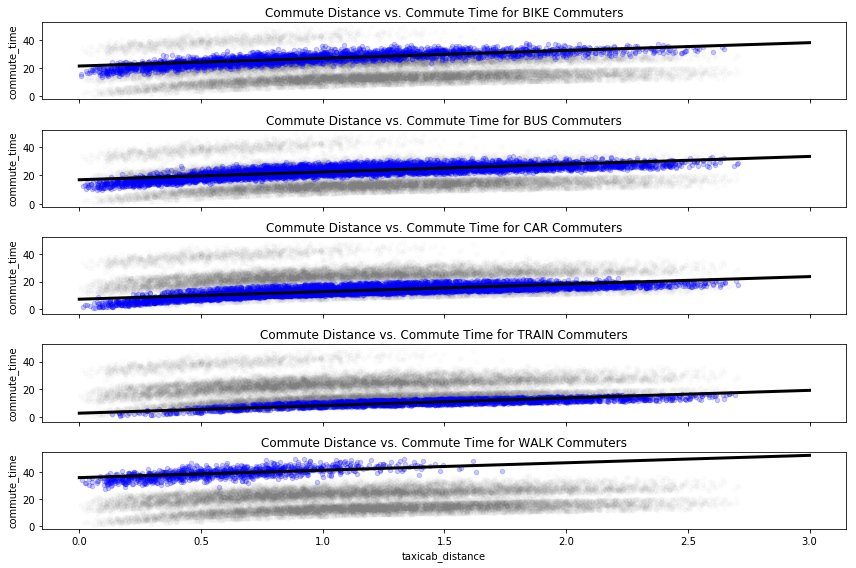

In [57]:
commute_types = np.unique(train_data_raw['commute_type'])

fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_data_raw.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='gray', alpha=0.02)
    train_for_commute_type.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='blue', alpha=0.2)
    plot_line(ax, 5.50, line_intercepts[commute_type])
    ax.set_title(f"Commute Distance vs. Commute Time for {commute_type} Commuters")

fig.tight_layout()

## Using Time of Day to Predict Commute Time

# Feature Creation

We're going ot need to create some new features to take advantage of what we've learned about our data.

## Commute Type Indicators

## Time of Day Indicators